In [1]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist
import itertools
import random
random.seed(42)
plt.style.use('dark_background')

Using TensorFlow backend.


# FindingMino Miniproject

- **Task**: take as input two MNIST images and through a neural network return the value of the minimum digit

- **Parameters**: no intermediate values can be used, ie a classifier that reveals what digits the images represent cannot be followed by logic to choose the lowest value

- **Approach**: as a variation of Gonzalo's proposed method, place images side-by-side and then make the label of that combined image be the minimum value

- **Implementation**: convolutional neural network with three convolutional layers interspersed by two max pooling layers, followed by a deep neural network with one hidden layer and a dropout layer prior to the output layer. 

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

(28, 28)


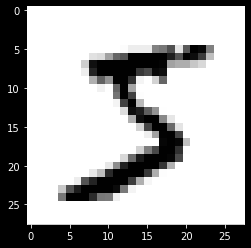

In [4]:
image_A = train_images[0]
print(image_A.shape)
plt.imshow(image_A, cmap = plt.cm.binary)

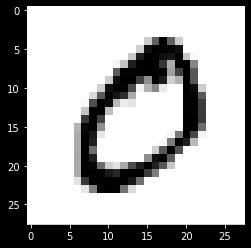

In [5]:
image_B = train_images[1]
plt.imshow(image_B, cmap = plt.cm.binary)

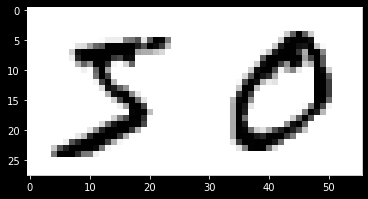

In [6]:
images_A_and_B = np.hstack((image_A, image_B))
plt.imshow(images_A_and_B, cmap = plt.cm.binary)

In [7]:
# Split training set further into training and validation sets
sample_size = 40000
X_train, X_val, y_train, y_val = train_images[:sample_size], train_images[sample_size:sample_size*2],  train_labels[:sample_size], train_labels[sample_size:sample_size*2]

Randomly sampling a subset of the data, to make the combinations more tractable. 

In [8]:
# Randomly draw from 40k training images

num_images_chosen = 400000
num_images_total = 40000

combo_train_X = []
combo_train_y = []

for i in range(num_images_chosen):
    
    # Randomly draw indices
    rand_A = random.randint(0, num_images_total-1)
    rand_B = random.randint(0, num_images_total-1)
    
    # Concatenate images
    image_A = X_train[rand_A]
    image_B = X_train[rand_B]
    concatenated_images = np.hstack((image_A, image_B))
    
    # Find the minimum label
    intermediate_label_A = y_train[rand_A]
    intermediate_label_B = y_train[rand_B]
    minimum_label = min(intermediate_label_A, intermediate_label_B)
    
    # Append to lists
    combo_train_X.append(concatenated_images)
    combo_train_y.append(minimum_label)

# Convert to numpy arrays so that they can be processed by the network
combo_train_X = np.array(combo_train_X)
combo_train_y = np.array(combo_train_y)

In [9]:
# Randomly draw 20k validation images

num_images_chosen = 10000
num_images_total = 20000

combo_val_X = []
combo_val_y = []

for i in range(num_images_chosen):
    
    # Randomly draw indices
    rand_A = random.randint(0, num_images_total-1)
    rand_B = random.randint(0, num_images_total-1)
    
    # Concatenate images
    image_A = X_val[rand_A]
    image_B = X_val[rand_B]
    concatenated_images = np.hstack((image_A, image_B))
    
    # Find the minimum label
    intermediate_label_A = y_val[rand_A]
    intermediate_label_B = y_val[rand_B]
    minimum_label = min(intermediate_label_A, intermediate_label_B)
    
    # Append to lists
    combo_val_X.append(concatenated_images)
    combo_val_y.append(minimum_label)
    
combo_val_X = np.array(combo_val_X)
combo_val_y = np.array(combo_val_y)

In [10]:
# Reshape the data so they can be fed into the network, one-hot-encode the labels

train_images = combo_train_X.reshape((combo_train_X.shape[0], 28, 56, 1))
train_images = train_images.astype('float32')/ 255

val_images = combo_val_X.reshape((combo_val_X.shape[0], 28, 56, 1))
val_images = val_images.astype('float32')/255

train_labels = to_categorical(combo_train_y)
val_labels = to_categorical(combo_val_y)

In [31]:
# Model architecture

# Convolutional NN
model = tf.keras.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,56,1)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
# Adding a NN Classifier
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 54, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 27, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 12, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 10, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)             

In [33]:
# Compile model
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0002)
model.compile(optimizer = opt,
             loss = 'categorical_crossentropy',
             metrics = ['mae', 'accuracy'])


In [14]:
# Fit model
model.fit(train_images, 
          train_labels, 
          epochs = 8, 
          batch_size = 64)


Epoch 1/4
4688/4688 [==============================] - 255s 54ms/step - loss: 0.3645 - mae: 0.0359 - accuracy: 0.8823
Epoch 2/4
4688/4688 [==============================] - 251s 54ms/step - loss: 0.1282 - mae: 0.0127 - accuracy: 0.9599
Epoch 3/4
4688/4688 [==============================] - 257s 55ms/step - loss: 0.0884 - mae: 0.0086 - accuracy: 0.9722
Epoch 4/4
4688/4688 [==============================] - 257s 55ms/step - loss: 0.0697 - mae: 0.0067 - accuracy: 0.9779


In [ ]:
# Create a set of predictions
y_predict = model.predict(val_images)

In [16]:
# Compare predictions to validation labels and return the proportion correctly classified
correct = 0

for label in range(len(val_labels)):
    
    if np.argmax(val_labels[label], axis=None, out=None) == np.argmax(y_predict[label], axis=None, out=None):
        correct = correct + 1
        
print("Val Accuracy: " + str(correct/len(val_labels)))

Val Accuracy: 0.983


In [ ]:
# Print loss, mae and accuracy
eval_model = model.evaluate(val_images, val_labels)
eval_model

In [38]:
# serialize model to JSON
model_json = model.to_json()
with open("Trained_Models/Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Trained_Models/Model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Verify above by visually inspecting images from the predicted set
num_val_images = 10000

Predicted: 2
True: 2


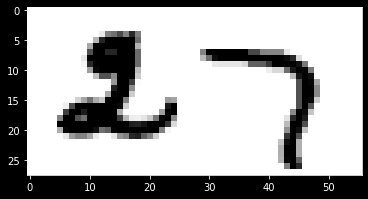

In [37]:
# Run this cell repeatedly to see multiple examples
check_index = random.randint(0,num_val_images)
plt.imshow(val_images[check_index], cmap = plt.cm.binary)
print("Predicted: " + str(np.argmax(y_predict[check_index])))
print("True: " + str(np.argmax(val_labels[check_index])))